In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
result_save_folder = "drive/MyDrive/farsi_eval/Codes/Entailment/Results/"

# Packages, Imports

In [ ]:
!pip install datasets
!pip install openai
!pip install googletrans
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 5.5 MB/s eta 0:

In [ ]:
import glob
import os

import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, ConfusionMatrixDisplay

import openai
import datasets
from tqdm import tqdm
import time

import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer,  MT5ForConditionalGeneration, MT5Tokenizer

import matplotlib.pyplot as plt

tqdm.pandas()

# OpenAI Interfaces

frist upload api key file with this name format: "openai_api_key*.txt" and then run

In [ ]:
api_key_path = glob.glob("openai_api_key*.txt")[0]
with open(api_key_path, 'r') as f:
    openai.api_key = f.read()

In [ ]:
def get_completion(prompt, model="gpt-3.5-turbo"):
    if type(prompt) == str:
        messages = [{"role": "user", "content": prompt}]
    elif type(prompt) == list:
        messages = prompt

    response = openai.ChatCompletion.create(
        model=model,
        messages=messages,
        temperature=0, # this is the degree of randomness of the model's output
    )
    return response.choices[0].message["content"]

# Datasets Load

In [ ]:
parsinlu_ent = datasets.load_dataset("persiannlp/parsinlu_entailment")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/755 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1675 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/270 [00:00<?, ? examples/s]

Dataset parsinlu_entailment downloaded and prepared to /root/.cache/huggingface/datasets/persiannlp___parsinlu_entailment/parsinlu-repo/1.0.0/a99ad431d1637751f03fa9da3de66a41e93983d11116a0918a6efaaa72343d2d. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
test_df = parsinlu_ent['test'].to_pandas()
train_df = parsinlu_ent['train'].to_pandas()

In [ ]:
labels = test_df['label'].unique()
print(labels)
labels = labels[:3]
print(labels)

['c' 'n' 'e' '-']
['c' 'n' 'e']


### remove unlabeled data

In [ ]:
test_df = test_df[test_df['label'] != '-']
train_df = train_df[train_df['label'] != 'xx']

### sampling

In [ ]:
def get_sample(data_df, each_class_n_samples):
    np.random.seed(42)
    sampled_data = data_df.groupby(['label']).apply(lambda x: x.sample(each_class_n_samples, random_state=42, replace=False))
    sampled_data = sampled_data.reset_index(drop=True).sample(frac=1)
    return sampled_data

In [ ]:
sample_df = get_sample(test_df, 4)
test_200_df = get_sample(test_df, 67)
train_1shot_df = get_sample(train_df, 1)
train_3shot_df = get_sample(train_df, 3)

In [ ]:
sample_df

,sent1,sent2,category,label
10,پس از آن موبد موبدان است که در جایگاه پیشوای پ...,هیربد در جایگاه آموزگار دین مزدیسنا است و در ر...,natural-wiki,n
9,در نهایت در سال ۱۳۶۰ جبهۀ ملی مرتد اعلام شده و...,رهبران جبهۀ ملی متواری شدند و بعدها گروههای زی...,natural-wiki,n
0,سپس باید از ابزاری مانند mkisofs برای ساخت فای...,نیازی به ایجاد تصویر لوح فشرده نیست.,natural-wiki,c
8,حمیره (اهواز)، روستایی از توابع بخش مرکزی شهرس...,اهواز مرکز استان خوزستان است.,natural-wiki,n
5,توهم خیانت همسر، یکی از آزاردهنده ترین مسائلی ...,یکی از عوامل جدایی توهم خیانت همسر است.,natural-miras,e
2,دادیار و بازپرس پس از ارجاع پرونده از سوی دادس...,تحقیقات مقدماتی پس از صدور قرار موقوفی تعقیب ا...,natural-wiki,c
1,حتی اگر شما یک نوع مسافر هستید که دوست دارد بد...,در دفاتر گردشگری چیزی که ارزش دیدن داشته باشد ...,translation-dev,c
11,خبرگزاری عربستان سعودی گزارش می دهد ملک فهد در...,بسیاری از شبکه های خبری این خبر را پوشش دادند.,natural-voa,n
4,در حالی که احتمالاً صحیح است که دموکراسی ها مع...,دموکراسی ها احتمالاً به جنگ نمی روند ، مگر این...,translation-dev,e
7,نخست وزيرعراق جدول زمانی آمريکا را رد کرد اما ...,نخست وزیر عراق با نقشه‌ی پیشنهادی آمریکا موافق...,natural-voa,e


#### j

In [ ]:
# np.random.seed(42)
# each_class_n_samples = 67
# test_200_df = test_df.groupby(['label']).apply(lambda x: x.sample(each_class_n_samples,random_state=42, replace=False))
# test_200_df = test_200_df.reset_index(drop=True).sample(frac=1)
# test_200_df

In [ ]:
# np.random.seed(42)
# each_class_n_samples = 34
# test_100_df = test_df.groupby(['label']).apply(lambda x: x.sample(each_class_n_samples,random_state=42, replace=False))
# test_100_df = test_100_df.reset_index(drop=True).sample(frac=1)
# test_100_df

In [ ]:
# each_class_n_samples = 2
# sample_train_df = train_df.groupby(['label']).apply(lambda x: x.sample(each_class_n_samples,random_state=42, replace=False))
# sample_train_df = sample_train_df.reset_index(drop=True)

# Utilities

In [ ]:
def run_prompts(prompts, label_names, actual_labels, save_path_prefix):
    max_end = -1
    for file_path in glob.glob(f"{save_path_prefix}*"):
        start_end = file_path.split('/')[-1].split('.')[0].split('__')[-1].split('_')
        max_end = max(max_end, int(start_end[1]))

    start_idx = max_end + 1
    end_idx = None
    last_file_saved = None

    prompts = prompts[start_idx:]
    actual_labels = actual_labels[start_idx:]

    responses = {'prompt': [], 'response': [], 'predicted_labels':[], 'actual_labels':[]}
    max_retries = 3
    for idx, p in enumerate(tqdm(prompts)):
        retries = 0
        while retries < max_retries:
            try:
                response = get_completion(p)
                responses['prompt'].append(p)
                responses['response'].append(response)

                if response not in label_names:
                    responses['predicted_labels'].append('OTHER')
                else:
                    responses['predicted_labels'].append(response)

                responses['actual_labels'].append(actual_labels[idx])

                end_idx = start_idx + idx
                if (idx+1) % 5 == 0:
                    save_path = f"{save_path_prefix}__{start_idx}_{end_idx}.csv"
                    pd.DataFrame(responses).to_csv(save_path, index=False)
                    if last_file_saved:
                        os.remove(last_file_saved)
                    last_file_saved = save_path

                break
            except Exception as e:
                if "JSON" not in str(e):
                    print(f"An error occurred: {str(e)}")
                    print(f"Retrying ({retries+1}/{max_retries})...")
                retries += 1
                time.sleep(60)

        time.sleep(22)

        if retries == max_retries:
            print(f"Failed to process prompt after {max_retries} retries. Process Finished.")
            break

    save_path = f"{save_path_prefix}__{start_idx}_{end_idx}.csv"
    pd.DataFrame(responses).to_csv(save_path, index=False)
    if (last_file_saved != None) and (last_file_saved != save_path):
        os.remove(last_file_saved)

    return responses

In [ ]:
def concatenate_results(save_path_prefix):
    result = None
    for file_path in glob.glob(f"{save_path_prefix}*"):
        df = pd.read_csv(file_path)
        if type(result) == 'NoneType':
            result = df
        else:
            result = pd.concat([result, df], axis=0)

    return result

# SOTA

In [ ]:
label_mapping = {
    "e": "entails",
    "c": "contradicts",
    "n": "neutral"
}

# Apply the mapping to the 'prediction' column in the DataFrame
test_200_df['label'] = test_200_df['label'].map(label_mapping)

## [Wiki Bert](https://huggingface.co/persiannlp/wikibert-base-parsinlu-entailment)

In [ ]:
labels = ["entails", "contradicts", "neutral"]
model_name_or_path = "persiannlp/wikibert-base-parsinlu-entailment"
model = AutoModelForSequenceClassification.from_pretrained(model_name_or_path)
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path,)

def model_predict(row):
    text_a = row['sent1']
    text_b = row['sent2']
    features = tokenizer( [(text_a, text_b)], padding="max_length", truncation=True, return_tensors='pt')
    output = model(**features)
    logits = output[0]
    probs = torch.nn.functional.softmax(logits, dim=1).tolist()
    idx = np.argmax(np.array(probs))

    return labels[idx]

In [ ]:
test_200_df['prediction_wiki_bert'] = test_200_df.apply(model_predict, axis=1, result_type='expand')

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
ground_truth = test_200_df['label'].tolist()
predicted_labels = test_200_df['prediction_wiki_bert'].tolist()
print(classification_report(ground_truth, predicted_labels))

              precision    recall  f1-score   support

 contradicts       0.46      0.49      0.47        67
     entails       0.55      0.54      0.54        67
     neutral       0.65      0.61      0.63        67

    accuracy                           0.55       201
   macro avg       0.55      0.55      0.55       201
weighted avg       0.55      0.55      0.55       201



## MT5 - Large

In [ ]:
!pip install sentencepiece

In [ ]:
label_mapping = {
    "entails": "e",
    "contradicts":"c",
    "neutral":"n"
}

# Apply the mapping to the 'prediction' column in the DataFrame
test_200_df['label'] = test_200_df['label'].map(label_mapping)

In [ ]:
model_size = "large"
model_name = f"persiannlp/mt5-{model_size}-parsinlu-snli-entailment"
tokenizer = MT5Tokenizer.from_pretrained(model_name)
model = MT5ForConditionalGeneration.from_pretrained(model_name)


You are using a model of type t5 to instantiate a model of type mt5. This is not supported for all configurations of models and can yield errors.


In [ ]:
def run_model(row, **generator_args):
    premise = row['sent1']
    hypothesis = row['sent2']
    input_ids = tokenizer.encode(f"{premise}<sep>{hypothesis}", return_tensors="pt")
    res = model.generate(input_ids, **generator_args)
    output = tokenizer.batch_decode(res, skip_special_tokens=True)
    #print(output)
    return output

In [ ]:
test_200_df['prediction_mt5_large'] = test_200_df.apply(run_model, axis=1, result_type='expand')

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [ ]:
ground_truth = test_200_df['label'].tolist()
predicted_labels = test_200_df['prediction_mt5_large'].tolist()
print(classification_report(ground_truth, predicted_labels))

              precision    recall  f1-score   support

           c       0.70      0.75      0.72        67
           e       0.69      0.60      0.64        67
           n       0.67      0.72      0.69        67

    accuracy                           0.69       201
   macro avg       0.69      0.69      0.69       201
weighted avg       0.69      0.69      0.69       201



## MT5 - Base

In [ ]:
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.5 MB/s eta 0:00:00


In [ ]:
label_mapping = {
    "entails": "e",
    "contradicts":"c",
    "neutral":"n"
}

# Apply the mapping to the 'prediction' column in the DataFrame
test_200_df['label'] = test_200_df['label'].map(label_mapping)

In [ ]:
model_size = "base"
model_name = f"persiannlp/mt5-{model_size}-parsinlu-snli-entailment"
tokenizer = MT5Tokenizer.from_pretrained(model_name)
model = MT5ForConditionalGeneration.from_pretrained(model_name)


You are using a model of type t5 to instantiate a model of type mt5. This is not supported for all configurations of models and can yield errors.


In [ ]:
def run_model(row, **generator_args):
    premise = row['sent1']
    hypothesis = row['sent2']
    input_ids = tokenizer.encode(f"{premise}<sep>{hypothesis}", return_tensors="pt")
    res = model.generate(input_ids, **generator_args)
    output = tokenizer.batch_decode(res, skip_special_tokens=True)
    #print(output)
    return output

In [ ]:
test_200_df['prediction_mt5_base'] = test_200_df.progress_apply(run_model, axis=1, result_type='expand')

100%|██████████| 201/201 [02:20<00:00,  1.43it/s]


In [ ]:
ground_truth = test_200_df['label'].tolist()
predicted_labels = test_200_df['prediction_mt5_base'].tolist()
print(classification_report(ground_truth, predicted_labels))

              precision    recall  f1-score   support

           c       0.57      0.58      0.57        67
           e       0.56      0.54      0.55        67
           n       0.59      0.60      0.59        67

    accuracy                           0.57       201
   macro avg       0.57      0.57      0.57       201
weighted avg       0.57      0.57      0.57       201



## ParsBert-base

In [ ]:
labels = ["entails", "contradicts", "neutral"]
model_name_or_path = "persiannlp/parsbert-base-parsinlu-entailment"
model = AutoModelForSequenceClassification.from_pretrained(model_name_or_path)
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path,)

def model_predict(row):
    text_a = row['sent1']
    text_b = row['sent2']
    features = tokenizer( [(text_a, text_b)], padding="max_length", truncation=True, return_tensors='pt')
    output = model(**features)
    logits = output[0]
    probs = torch.nn.functional.softmax(logits, dim=1).tolist()
    idx = np.argmax(np.array(probs))

    return labels[idx]



In [ ]:
test_200_df['prediction_parsbert'] = test_200_df.progress_apply(model_predict, axis=1, result_type='expand')

  0%|          | 0/201 [00:00<?, ?it/s]Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
100%|██████████| 201/201 [01:02<00:00,  3.24it/s]


In [ ]:
ground_truth = test_200_df['label'].tolist()
predicted_labels = test_200_df['prediction_parsbert'].tolist()
print(classification_report(ground_truth, predicted_labels))

              precision    recall  f1-score   support

 contradicts       0.46      0.54      0.49        67
     entails       0.51      0.46      0.48        67
     neutral       0.62      0.57      0.59        67

    accuracy                           0.52       201
   macro avg       0.53      0.52      0.52       201
weighted avg       0.53      0.52      0.52       201



## mBERT - Base

In [ ]:
labels = ["entails", "contradicts", "neutral"]
model_name_or_path = "persiannlp/mbert-base-parsinlu-entailment"
model = AutoModelForSequenceClassification.from_pretrained(model_name_or_path)
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path,)

def model_predict(row):
    text_a = row['sent1']
    text_b = row['sent2']
    features = tokenizer( [(text_a, text_b)], padding="max_length", truncation=True, return_tensors='pt')
    output = model(**features)
    logits = output[0]
    probs = torch.nn.functional.softmax(logits, dim=1).tolist()
    idx = np.argmax(np.array(probs))

    return labels[idx]

In [ ]:
test_200_df['prediction_mbert_base'] = test_200_df.progress_apply(model_predict, axis=1, result_type='expand')

100%|██████████| 201/201 [07:46<00:00,  2.32s/it]


In [ ]:
ground_truth = test_200_df['label'].tolist()
predicted_labels = test_200_df['prediction_mbert_base'].tolist()
print(classification_report(ground_truth, predicted_labels))

              precision    recall  f1-score   support

 contradicts       0.52      0.48      0.50        67
     entails       0.54      0.60      0.57        67
     neutral       0.68      0.66      0.67        67

    accuracy                           0.58       201
   macro avg       0.58      0.58      0.58       201
weighted avg       0.58      0.58      0.58       201



# Random Classifier

In [ ]:
np.random.seed(42)
random_predicted_labels = np.random.choice(['e', 'c', 'n'], test_200_df.shape[0])
actual_labels = test_200_df['label'].to_numpy()

print(classification_report(actual_labels, random_predicted_labels,
                            labels=['e', 'c', 'n'],
                            target_names=['entailment', 'contradiction', 'neutral'],
                            zero_division=0))

               precision    recall  f1-score   support

   entailment       0.34      0.34      0.34        67
contradiction       0.36      0.33      0.34        67
      neutral       0.38      0.42      0.40        67

     accuracy                           0.36       201
    macro avg       0.36      0.36      0.36       201
 weighted avg       0.36      0.36      0.36       201



# Persian Prompt + 0,1,3 Shots

## Test Two Prompt with Few Shot

### prompt 1

In [ ]:
label_mapping = lambda x: {
    'c': 'تناقض',
    'e': 'تناظر',
    'n': 'ناشناخته'
}[x]

test_examples_with_label = []
for idx, row in train_1shot_df.iterrows():
    ex = \
f"""-
<پیش‌فرض>:
    <{row['sent1']}>
<فرضیه>:
    <{row['sent2']}>
<برچسب>:
    {label_mapping(row['label'])}

"""
    test_examples_with_label.append(ex)

In [ ]:
test_examples = []
actual_labels = []
for idx, row in test_200_df.iterrows():
    ex = \
f"""\
<پیش‌فرض>:
    <{row['sent1']}>
<فرضیه>:
    <{row['sent2']}>
<برچسب>:
    ?\
"""
    test_examples.append(ex)
    actual_labels.append(row['label'])

actual_labels = list(map(label_mapping, actual_labels))

In [ ]:
prompt = f"""\
هدف وظیفه‌ی استنتاج زبان طبیعی تشخیص رابطه‌ی نتیجه‌گیری بین یک <فرضیه> با توجه به یک <پیش‌فرض> است.
رابطه‌ یا برچسب میان آن‌ها می‌تواند یکی از سه نوع تناظر، تناقض یا ناشناخته باشد.
۱- تناظر : اگر جمله <فرضیه> به طور منطقی نتیجه‌ای از جمله <پیش‌فرض> باشد
۲- تناقض : اگر جمله <فرضیه> به طور منطقی با جمله <پیش‌فرض> در تناقض باشد
۳- ناشناخته : اگر رابطه‌ای قطعی بین جمله <پیش‌فرض> و جمله <فرضیه> وجود نداشته باشد و هیچ تناظر یا تناقضی نتوان برقرار کرد
برای نمونه تست نام محتمل‌ترین برچسب را چاپ کن:

مثال:
{''.join(test_examples_with_label)}

تست:
-
TEST_EXAMPLE\
"""

fewshot_prompts = []
for te in test_examples:
    fewshot_prompts.append(prompt.replace('TEST_EXAMPLE', te))

In [ ]:
label_names = ['ناشناخته', 'تناظر', 'تناقض']
predicted_labels = run_prompts(fewshot_prompts, label_names)

100%|██████████| 102/102 [38:41<00:00, 22.76s/it]


In [ ]:
# accuracy_score(actual_labels, predicted_labels)
print(classification_report(actual_labels, predicted_labels,
                            labels=['تناظر', 'تناقض', 'ناشناخته'],
                            target_names=['ent', 'cont', 'neut'],
                            zero_division=0))

              precision    recall  f1-score   support

         ent       0.71      0.15      0.24        34
        cont       0.29      0.06      0.10        34
        neut       0.38      0.97      0.54        34

    accuracy                           0.39       102
   macro avg       0.46      0.39      0.29       102
weighted avg       0.46      0.39      0.29       102



### prompt 2

In [ ]:
label_mapping = lambda x: {
    'c': 'تناقض',
    'e': 'تناظر',
    'n': 'ناشناخته'
}[x]

test_examples_with_label = []
for idx, row in train_1shot_df.iterrows():
    ex = \
f"""<{row['sent1']}><sep><{row['sent2']}>
<برچسب>:
    {label_mapping(row['label'])}

"""
    test_examples_with_label.append(ex)

In [ ]:
test_examples = []
actual_labels = []
for idx, row in test_200_df.iterrows():
    ex = \
f"""<{row['sent1']}><sep><{row['sent2']}>
<برچسب>:
    ?\
"""
    test_examples.append(ex)
    actual_labels.append(row['label'])

actual_labels = list(map(label_mapping, actual_labels))

In [ ]:
prompt = f"""\
هدف وظیفه‌ی استنتاج زبان طبیعی تشخیص رابطه‌ی نتیجه‌گیری بین یک <فرضیه> با توجه به یک <پیش‌فرض> است.
رابطه‌ یا برچسب میان آن‌ها می‌تواند یکی از سه نوع تناظر، تناقض یا ناشناخته باشد.
۱- تناظر : اگر جمله <فرضیه> به طور منطقی نتیجه‌ای از جمله <پیش‌فرض> باشد
۲- تناقض : اگر جمله <فرضیه> به طور منطقی با جمله <پیش‌فرض> در تناقض باشد
۳- ناشناخته : اگر رابطه‌ای قطعی بین جمله <پیش‌فرض> و جمله <فرضیه> وجود نداشته باشد و هیچ تناظر یا تناقضی نتوان برقرار کرد
برای نمونه تست نام محتمل‌ترین برچسب را چاپ کن:

مثال:
<پیش‌فرض><sep><فرضیه>
<برچسب>:
    تناقض یا تناظر یا ناشناخته

{''.join(test_examples_with_label)}
تست:
TEST_EXAMPLE\
"""

fewshot_prompts = []
for te in test_examples:
    fewshot_prompts.append(prompt.replace('TEST_EXAMPLE', te))

In [ ]:
label_names = ['ناشناخته', 'تناظر', 'تناقض']
predicted_labels = run_prompts(fewshot_prompts, label_names)

100%|██████████| 201/201 [1:13:14<00:00, 21.86s/it]


In [ ]:
# accuracy_score(actual_labels, predicted_labels)
print(classification_report(actual_labels, predicted_labels,
                            labels=['تناظر', 'تناقض', 'ناشناخته'],
                            target_names=['ent', 'cont', 'neut'],
                            zero_division=0))

              precision    recall  f1-score   support

         ent       0.71      0.15      0.25        67
        cont       0.38      0.09      0.14        67
        neut       0.36      0.93      0.52        67

    accuracy                           0.39       201
   macro avg       0.48      0.39      0.30       201
weighted avg       0.48      0.39      0.30       201



## Zero Shot

In [ ]:
label_mapping = lambda x: {
    'c': 'تناقض',
    'e': 'تناظر',
    'n': 'ناشناخته'
}[x]

test_examples = []
actual_labels = []
for idx, row in test_200_df.iterrows():
    ex = \
f"""<{row['sent1']}><sep><{row['sent2']}>
<برچسب>:
    ?\

"""
    test_examples.append(ex)
    actual_labels.append(row['label'])

actual_labels = list(map(label_mapping, actual_labels))

In [ ]:
prompt = f"""\
هدف وظیفه‌ی استنتاج زبان طبیعی تشخیص رابطه‌ی نتیجه‌گیری بین یک <فرضیه> با توجه به یک <پیش‌فرض> است.
رابطه‌ یا برچسب میان آن‌ها می‌تواند یکی از سه نوع تناظر، تناقض یا ناشناخته باشد.
- تناظر : اگر جمله <فرضیه> به طور منطقی نتیجه‌ای از جمله <پیش‌فرض> باشد
- تناقض : اگر جمله <فرضیه> با جمله <پیش‌فرض> در تناقض باشد
- ناشناخته : اگر رابطه‌ای قطعی بین جمله <پیش‌فرض> و جمله <فرضیه> وجود نداشته باشد و هیچ تناظر یا تناقضی نتوان برقرار کرد

الگوی نمونه:
<پیش‌فرض><sep><فرضیه>
<برچسب>:
    تناقض یا تناظر یا ناشناخته

برای نمونه تست زیر نام محتمل‌ترین برچسب را چاپ کن:
TEST_EXAMPLE\
"""

zero_shot_prompts = []
for te in test_examples:
    zero_shot_prompts.append(prompt.replace('TEST_EXAMPLE', te))

In [ ]:
label_names = ['تناظر', 'تناقض', 'ناشناخته']
save_path_prefix = result_save_folder + "p_fa__0shot"

In [ ]:
responses = run_prompts(zero_shot_prompts, label_names, actual_labels, save_path_prefix)

100%|██████████| 162/162 [1:02:14<00:00, 23.05s/it]


In [ ]:
responses = concatenate_results(save_path_prefix)
print(classification_report(responses['actual_labels'], responses['predicted_labels'],
                            labels=label_names,
                            target_names=['ent', 'cont', 'neut'],
                            zero_division=0,
                            digits=3))

              precision    recall  f1-score   support

         ent      0.393     0.164     0.232        67
        cont      0.513     0.299     0.377        67
        neut      0.388     0.776     0.517        67

    accuracy                          0.413       201
   macro avg      0.431     0.413     0.375       201
weighted avg      0.431     0.413     0.375       201



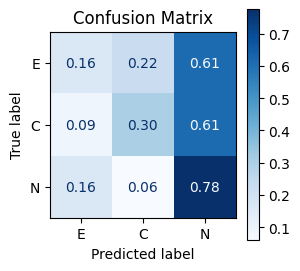

In [ ]:
fig, ax = plt.subplots(figsize=(3, 3))
ConfusionMatrixDisplay.from_predictions(responses['actual_labels'], responses['predicted_labels'], cmap='Blues',
                                        labels=label_names, display_labels=['E', 'C', 'N'], normalize='true', ax=ax,values_format='.2f')
ax.set_title("Confusion Matrix")
plt.show()

## Few Shot

In [ ]:
def create_examples_with_labels(examples_df, label_mapping):
    examples_with_label = []
    for idx, row in examples_df.iterrows():
        ex = \
f"""<{row['sent1']}><sep><{row['sent2']}>
<برچسب>:
    {label_mapping(row['label'])}

"""
        examples_with_label.append(ex)

    return examples_with_label

In [ ]:
def create_examples_without_labels(examples_df, label_mapping):
    examples_without_label = []
    actual_labels = []
    for idx, row in examples_df.iterrows():
        ex = \
f"""<{row['sent1']}><sep><{row['sent2']}>
<برچسب>:
    ?\
"""
        examples_without_label.append(ex)
        actual_labels.append(row['label'])

    actual_labels = list(map(label_mapping, actual_labels))

    return examples_without_label, actual_labels

In [ ]:
def create_prompts(examples_with_label, examples_without_label):
    prompt = f"""\
هدف وظیفه‌ی استنتاج زبان طبیعی تشخیص رابطه‌ی نتیجه‌گیری بین یک <فرضیه> با توجه به یک <پیش‌فرض> است.
رابطه‌ یا برچسب میان آن‌ها می‌تواند یکی از سه نوع تناظر، تناقض یا ناشناخته باشد.
- تناظر : اگر جمله <فرضیه> به طور منطقی نتیجه‌ای از جمله <پیش‌فرض> باشد
- تناقض : اگر جمله <فرضیه> با جمله <پیش‌فرض> در تناقض باشد
- ناشناخته : اگر رابطه‌ای قطعی بین جمله <پیش‌فرض> و جمله <فرضیه> وجود نداشته باشد و هیچ تناظر یا تناقضی نتوان برقرار کرد

مثال:
<پیش‌فرض><sep><فرضیه>
<برچسب>:
    تناقض یا تناظر یا ناشناخته

{''.join(examples_with_label)}

برای نمونه تست زیر نام محتمل‌ترین برچسب را چاپ کن:
TEST_EXAMPLE\
"""

    prompts = []
    for te in examples_without_label:
        prompts.append(prompt.replace('TEST_EXAMPLE', te))

    return prompts

### 1-Shot

In [ ]:
label_mapping = lambda x: {
    'c': 'تناقض',
    'e': 'تناظر',
    'n': 'ناشناخته'
}[x]
examples_with_label = create_examples_with_labels(train_1shot_df, label_mapping)
examples_without_label, actual_labels = create_examples_without_labels(test_200_df, label_mapping)
one_shot_prompts = create_prompts(examples_with_label, examples_without_label)

In [ ]:
label_names = ['تناظر', 'تناقض', 'ناشناخته']
save_path_prefix = result_save_folder + "p_fa__1shot"

In [ ]:
responses = run_prompts(one_shot_prompts, label_names, actual_labels, save_path_prefix)

100%|██████████| 201/201 [1:16:23<00:00, 22.80s/it]


In [ ]:
responses = concatenate_results(save_path_prefix)
print(classification_report(responses['actual_labels'], responses['predicted_labels'],
                            labels=label_names,
                            target_names=['entailment', 'contradiction', 'neutral'],
                            zero_division=0,
                            digits=3))

               precision    recall  f1-score   support

   entailment      0.667     0.119     0.203        67
contradiction      0.550     0.164     0.253        67
      neutral      0.349     0.881     0.500        67

     accuracy                          0.388       201
    macro avg      0.522     0.388     0.318       201
 weighted avg      0.522     0.388     0.318       201



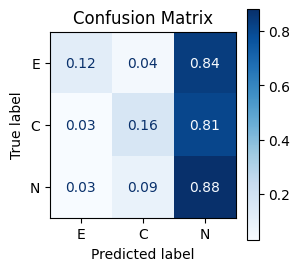

In [ ]:
fig, ax = plt.subplots(figsize=(3, 3))
ConfusionMatrixDisplay.from_predictions(responses['actual_labels'], responses['predicted_labels'], cmap='Blues',
                                        labels=label_names, display_labels=['E', 'C', 'N'], normalize='true', ax=ax,values_format='.2f')
ax.set_title("Confusion Matrix")
plt.show()

### 3-Shot

In [ ]:
label_mapping = lambda x: {
    'c': 'تناقض',
    'e': 'تناظر',
    'n': 'ناشناخته'
}[x]
examples_with_label = create_examples_with_labels(train_3shot_df, label_mapping)
examples_without_label, actual_labels = create_examples_without_labels(test_200_df, label_mapping)
three_shot_prompts = create_prompts(examples_with_label, examples_without_label)

In [ ]:
label_names = ['تناظر', 'تناقض', 'ناشناخته']
save_path_prefix = result_save_folder + "p_fa__3shot"

In [ ]:
responses = run_prompts(three_shot_prompts, label_names, actual_labels, save_path_prefix)

100%|██████████| 52/52 [19:59<00:00, 23.07s/it]


In [ ]:
responses = concatenate_results(save_path_prefix)
print(classification_report(responses['actual_labels'], responses['predicted_labels'],
                            labels=label_names,
                            target_names=['entailment', 'contradiction', 'neutral'],
                            zero_division=0,
                            digits=3))

               precision    recall  f1-score   support

   entailment      0.875     0.104     0.187        67
contradiction      0.407     0.164     0.234        67
      neutral      0.380     0.940     0.541        67

     accuracy                          0.403       201
    macro avg      0.554     0.403     0.320       201
 weighted avg      0.554     0.403     0.320       201



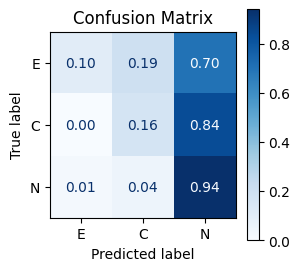

In [ ]:
fig, ax = plt.subplots(figsize=(3, 3))
ConfusionMatrixDisplay.from_predictions(responses['actual_labels'], responses['predicted_labels'], cmap='Blues',
                                        labels=label_names, display_labels=['E', 'C', 'N'], normalize='true', ax=ax,values_format='.2f')
ax.set_title("Confusion Matrix")
plt.show()

# English Prompt + 0,1,3 Shots

## Zero Shot

In [ ]:
label_mapping = lambda x: {
    'c': 'contradiction',
    'e': 'entailment',
    'n': 'neutral'
}[x]

test_examples = []
actual_labels = []
for idx, row in test_200_df.iterrows():
    ex = \
f"""<{row['sent1']}><sep><{row['sent2']}>
<category>:
    ?\
"""
    test_examples.append(ex)
    actual_labels.append(row['label'])

actual_labels = list(map(label_mapping, actual_labels))

In [ ]:
prompt = f"""\
Natural Language Inference: Read the following premise and hypothesis carefully and determine the relationship between them.
Choose one of the three categories below that best describes their relationship:

- entailment: The meaning of the hypothesis is logically inferred or derived from the premise.
- contradiction: The meaning of the hypothesis contradicts or conflicts with the premise.
- neutral: There is no clear logical relationship between the premise and hypothesis.

Note: The premise and hypothesis are in Persian.

example pattern:
<premise><sep><hypothesis>
<category>:
    entailment or contradiction or neutral

Please select the appropriate category for the given example:
TEST_EXAMPLE\
"""

zero_shot_prompts = []
for te in test_examples:
    zero_shot_prompts.append(prompt.replace('TEST_EXAMPLE', te))

In [ ]:
label_names = ['entailment', 'contradiction', 'neutral']
save_path_prefix = result_save_folder + "p_en__0shot"

In [ ]:
responses = run_prompts(zero_shot_prompts, label_names, actual_labels, save_path_prefix)

100%|██████████| 201/201 [1:15:42<00:00, 22.60s/it]


In [ ]:
responses = concatenate_results(save_path_prefix)
print(classification_report(responses['actual_labels'], responses['predicted_labels'],
                            labels=['entailment', 'contradiction', 'neutral'],
                            target_names=['entailment', 'contradiction', 'neutral'],
                            zero_division=0,
                            digits=3))

               precision    recall  f1-score   support

   entailment      0.527     0.433     0.475        67
contradiction      0.576     0.567     0.571        67
      neutral      0.519     0.612     0.562        67

    micro avg      0.540     0.537     0.539       201
    macro avg      0.541     0.537     0.536       201
 weighted avg      0.541     0.537     0.536       201



In [ ]:
print("Accuracy: ", accuracy_score(responses['actual_labels'], responses['predicted_labels']))

Accuracy:  0.5373134328358209


## Few Shot

In [ ]:
def create_examples_with_labels(examples_df, label_mapping):
    examples_with_label = []
    for idx, row in examples_df.iterrows():
        ex = \
f"""<{row['sent1']}><sep><{row['sent2']}>
<category>:
    {label_mapping(row['label'])}

"""
        examples_with_label.append(ex)

    return examples_with_label

In [ ]:
def create_examples_without_labels(examples_df, label_mapping):
    examples_without_label = []
    actual_labels = []
    for idx, row in examples_df.iterrows():
        ex = \
f"""<{row['sent1']}><sep><{row['sent2']}>
<category>:
    ?\
"""
        examples_without_label.append(ex)
        actual_labels.append(row['label'])

    actual_labels = list(map(label_mapping, actual_labels))

    return examples_without_label, actual_labels

In [ ]:
def create_prompts(examples_with_label, examples_without_label):
    prompt = f"""\
Natural Language Inference: Read the following premise and hypothesis carefully and determine the relationship between them.
Choose one of the three categories below that best describes their relationship:

- entailment: The meaning of the hypothesis is logically inferred or derived from the premise.
- contradiction: The meaning of the hypothesis contradicts or conflicts with the premise.
- neutral: There is no clear logical relationship between the premise and hypothesis.

Note: The premise and hypothesis are in Persian.

examples:
<premise><sep><hypothesis>
<category>:
    entailment or contradiction or neutral

{''.join(examples_with_label)}

Please select the appropriate category for the given example:
TEST_EXAMPLE\
"""

    prompts = []
    for te in examples_without_label:
        prompts.append(prompt.replace('TEST_EXAMPLE', te))

    return prompts

### 1-Shot

In [ ]:
label_mapping = lambda x: {
    'c': 'contradiction',
    'e': 'entailment',
    'n': 'neutral'
}[x]
examples_with_label = create_examples_with_labels(train_1shot_df, label_mapping)
examples_without_label, actual_labels = create_examples_without_labels(test_200_df, label_mapping)
one_shot_prompts = create_prompts(examples_with_label, examples_without_label)

In [ ]:
label_names = ['entailment', 'contradiction', 'neutral']
save_path_prefix = result_save_folder + "p_en__1shot"

In [ ]:
responses = run_prompts(one_shot_prompts, label_names, actual_labels, save_path_prefix)

 25%|██▍       | 50/201 [18:51<56:59, 22.64s/it]

An error occurred: The server is overloaded or not ready yet.
Retrying (1/3)...


100%|██████████| 201/201 [1:17:05<00:00, 23.01s/it]


In [ ]:
responses = concatenate_results(save_path_prefix)
print(classification_report(responses['actual_labels'], responses['predicted_labels'],
                            labels=label_names,
                            target_names=label_names,
                            zero_division=0,
                            digits=3))

               precision    recall  f1-score   support

   entailment      0.516     0.493     0.504        67
contradiction      0.646     0.463     0.539        67
      neutral      0.511     0.672     0.581        67

    micro avg      0.545     0.542     0.544       201
    macro avg      0.558     0.542     0.541       201
 weighted avg      0.558     0.542     0.541       201



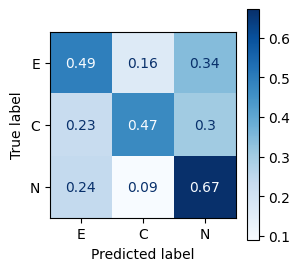

In [ ]:
fig, ax = plt.subplots(figsize=(3, 3))
ConfusionMatrixDisplay.from_predictions(responses['actual_labels'], responses['predicted_labels'], cmap='Blues',
                                        labels=label_names, display_labels=['E', 'C', 'N'], normalize='true', ax=ax)
plt.show()

In [ ]:
print("Accuracy: ", accuracy_score(responses['actual_labels'], responses['predicted_labels']))

Accuracy:  0.5422885572139303


### 3-Shot

In [ ]:
label_mapping = lambda x: {
    'c': 'contradiction',
    'e': 'entailment',
    'n': 'neutral'
}[x]

examples_with_label = create_examples_with_labels(train_3shot_df, label_mapping)
examples_without_label, actual_labels = create_examples_without_labels(test_200_df, label_mapping)
three_shot_prompts = create_prompts(examples_with_label, examples_without_label)

In [ ]:
label_names = ['entailment', 'contradiction', 'neutral']
save_path_prefix = result_save_folder + "p_en__3shot"

In [ ]:
responses = run_prompts(three_shot_prompts, label_names, actual_labels, save_path_prefix)

 46%|████▌     | 92/201 [34:52<41:42, 22.96s/it]

An error occurred: The server is overloaded or not ready yet.
Retrying (1/3)...


 52%|█████▏    | 104/201 [40:54<37:23, 23.12s/it]

An error occurred: The server is overloaded or not ready yet.
Retrying (1/3)...


100%|██████████| 201/201 [1:19:11<00:00, 23.64s/it]


In [ ]:
responses = concatenate_results(save_path_prefix)
print(classification_report(responses['actual_labels'], responses['predicted_labels'],
                            labels=label_names,
                            target_names=label_names,
                            zero_division=0,
                            digits=3))

               precision    recall  f1-score   support

   entailment      0.649     0.358     0.462        67
contradiction      0.529     0.552     0.540        67
      neutral      0.468     0.657     0.547        67

     accuracy                          0.522       201
    macro avg      0.548     0.522     0.516       201
 weighted avg      0.548     0.522     0.516       201



# English Prompt + 3 Shot + Use Fewshot Like Chat

In [ ]:
def create_examples_with_labels_messages(examples_df, label_mapping):
    messages = []
    for idx, row in examples_df.iterrows():
        ex = \
f"""Select the category of below example:
we know <{row['sent1']}>, what is relation of <{row['sent2']}> with that?
<category>:
    ?\
"""
        ex_label = f"{label_mapping(row['label'])}"

        messages += [
            {"role": "user", "content": ex},
            {"role": "assistant", "content": ex_label}
        ]

    return messages

In [ ]:
def create_examples_without_labels_messages(examples_df, label_mapping):
    messages = []
    actual_labels = []
    for idx, row in examples_df.iterrows():
        ex = \
f"""Select the category of below example:
we know <{row['sent1']}>, what is relation of <{row['sent2']}> with that?
<category>:
    ?\
"""
        messages.append({"role": "user", "content": ex})
        actual_labels.append(row['label'])

    actual_labels = list(map(label_mapping, actual_labels))

    return messages, actual_labels

In [ ]:
def create_messages(examples_with_label, examples_without_label):
    task_description = """\
Your task is Natural Language Inference. Read premise and hypothesis carefully and determine the relationship between them.
Choose one of the three categories below that best describes their relationship:

- entailment: The meaning of the hypothesis is logically inferred or derived from the premise.
- contradiction: The meaning of the hypothesis contradicts or conflicts with the premise.
- neutral: There is no clear logical relationship between the premise and hypothesis.

Note: The premise and hypothesis are in Persian.
"""

    example_patterns = """\
This is examples pattern:
we know <premise>, what is relation of <hypothesis> with that?
<category>:
    entailment or contradiction or neutral\
"""

    messages = [
        {"role": "system", "content": "You are a helpful, pattern-following assistant."},
        {"role": "user", "content": task_description},
        {"role": "assistant", "content": "OK, I got it. I will do the natural language inference task for Persian premise and hypothesis sentences"},
        {"role": "user", "content": example_patterns},
        {"role": "assistant", "content": "Ok. I am waiting to recieve examples in that format."},
    ]

    messages += examples_with_label

    prompt_messages = []
    for ewol in examples_without_label:
        context = messages.copy()
        context.append(ewol)
        prompt_messages.append(context)

    return prompt_messages

## 3-shot

In [ ]:
label_mapping = lambda x: {
    'c': 'contradiction',
    'e': 'entailment',
    'n': 'neutral'
}[x]

examples_with_label = create_examples_with_labels_messages(train_3shot_df, label_mapping)
examples_without_label, actual_labels = create_examples_without_labels_messages(sample_df, label_mapping)
one_shot_messages = create_messages(examples_with_label, examples_without_label)

In [ ]:
label_names = ['entailment', 'contradiction', 'neutral']
save_path_prefix = result_save_folder + "p_en__chat__12sample__3shot"
responses = run_prompts(one_shot_messages, label_names, actual_labels, save_path_prefix)

100%|██████████| 12/12 [04:39<00:00, 23.26s/it]


In [ ]:
responses = concatenate_results(save_path_prefix)
print(classification_report(responses['actual_labels'], responses['predicted_labels'],
                            labels=label_names,
                            target_names=label_names,
                            zero_division=0))

               precision    recall  f1-score   support

   entailment       0.40      1.00      0.57         4
contradiction       1.00      0.50      0.67         4
      neutral       0.00      0.00      0.00         4

     accuracy                           0.50        12
    macro avg       0.47      0.50      0.41        12
 weighted avg       0.47      0.50      0.41        12

